# Exploring stochastic gradient descent manually 

# Important equations 

$\text{ In this example we make use of the MNIST digit data for a feedforward neural network.  Gradients are calculated
 using backpropagation.}$

In [1]:

#import tensorflow as tf
#training_data, test_data = tf.keras.datasets.mnist.load_data()
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe


import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)


In [4]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


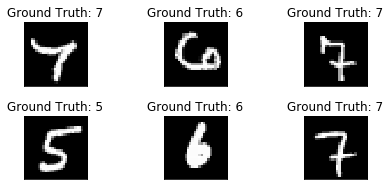

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    


In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


In [10]:
network = Net()

In [11]:
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)

In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [13]:
test_counter

[0, 60000, 120000, 180000]

In [14]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
    
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #epoch, batch_idx * len(data), len(train_loader.dataset),
            #100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimizer.pth')

In [15]:
!ls

CNN-test.ipynb	NLP_new.ipynb  train.csv
data		optimizer.pth  train-images-idx3-ubyte.gz
mnist.pkl.gz	readme	       train-images-idx3-ubyte.gz.1
mnist.pkl.gz.1	README.md      train-labels-idx1-ubyte.gz
model.pth	spam.csv       train-labels-idx1-ubyte.gz.1
NLP		test.csv


In [16]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            #print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            #test_loss, correct, len(test_loader.dataset),
            #100. * correct / len(test_loader.dataset)))

In [17]:

for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Text(0, 0.5, 'negative log likelihood loss')

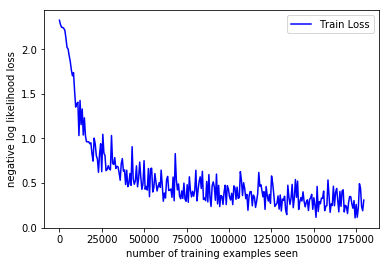

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
#plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


In [24]:
len(test_counter), len(test_losses)

(6, 50)

In [25]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)


In [26]:
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict (network_state_dict)
optimizer_state_dict = torch.load('optimizer.pth')

continued_optimizer.load_state_dict(optimizer_state_dict)




In [27]:
for i in range(8,10):
    test_counter.append(i*len(train_loader.dataset))
    train(i)

    test()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [23]:
#print("Model's state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

